In [2]:
!pip install catboost

In [3]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
import matplotlib as mpl
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()




# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/대학원1학기/데이콘'

In [15]:
import os
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))
sub = pd.read_csv(os.path.join(path,"sample_submission.csv"))
sub = sub.loc[-sub['code'].isin(['C2675', 'C2335', 'C1327']),:].reset_index(drop=True)
#test['단지코드'].unique()

In [13]:
class preprocess:
    
    def __init__(self,train,test,drop_col_name):
        self.train = train
        self.non_unique = np.array(['자격유형', '공급유형', '임대건물구분','임대보증금', '임대료', '전용면적', '전용면적별세대수'])
        self.test = test
        self.drop_col_name = drop_col_name
        
    def final(self):

        preprocess.no_duplicates(self,self.train)
        preprocess.process(self,self.train)
        res1 = preprocess.drop_col(self,self.drop_col_name)
        
        print('====train done====')
        
        preprocess.no_duplicates(self,self.test)
        preprocess.process(self,self.test)
        res2 = preprocess.drop_col(self,self.drop_col_name)
        print('====test done====')
        
        return res1, res2
        
        
    def no_duplicates(self,df): 
        
        self.newDF = df.drop(self.non_unique,axis=1).drop_duplicates().reset_index(drop=True)
        print(self.newDF.shape)

    def merge(self,col,standard,oldDF,newDF,kind):
        
        sample = oldDF.groupby('단지코드').describe()[col].reset_index()
        for i in sample.index:
            for j in standard:
                code = sample.loc[i,'단지코드']
                val = sample.loc[i,j]
                ind = newDF[newDF['단지코드']==code].index
                newDF.loc[ind,kind+col+j] = val
        return newDF
    
    def category(self,x,dic):
        for i in dic.keys():
            if x in dic[i]:
                return int(i)
        
    def grouping(self,col,dic,oldDF,newDF,count):
        oldDF[col+'카테고리'] = oldDF[col].apply(lambda x : preprocess.category(self,x,dic))
        sample = pd.DataFrame(oldDF.groupby('단지코드')[col+'카테고리'].unique()).reset_index()
        for i in dic.keys():
            newDF[col+str(i)]=0
        for i in sample.index:
            code = sample.loc[i,'단지코드']
            val = sample.loc[i,col+'카테고리']
            ind = newDF[newDF['단지코드']==code].index
            for j in val:
                if count == None:
                  newDF.loc[ind,col+str(j)] = 1  
                else:
                  newDF.loc[ind,col+str(j)] = newDF.loc[ind,count]
        newDF = newDF.drop(col+str(1),axis=1)
        return newDF
                    
    
    def process(self,df):
        
        self.apt = df[df['임대건물구분']=='아파트']
        self.store= df[df['임대건물구분']=='상가']
        
        #아파트 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')
        self.newDF = preprocess.merge(self,'임대보증금',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt')

        #상가 임대료, 임대보증금
        self.newDF = preprocess.merge(self,'임대료',['min','25%','50%','75%','max'],self.store,self.newDF,'store')
        self.newDF = preprocess.merge(self,'임대보증금',['min','25%','50%','75%','max'],self.store,self.newDF,'store')

        #상가 없는 경우 임대료 임대보증금 0으로 채움
        self.newDF = self.newDF.replace(np.nan, 0)

        # 자격유형 0,1 indicator variable
        dic = {'1': 'A' ,'2':['E','K'],'3':['D'],'4':['L','M','N','O'],'5':['B','H','I','G'],'6':'J','7':['C','F']}
        self.newDF = preprocess.grouping(self,'자격유형',dic,df,self.newDF,count=None)
        df = df.drop('자격유형카테고리',axis=1)
        
        # 지역
        dic = {'1':['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시'],'2':['경기도' ,'서울특별시', '대구광역시' ,'부산광역시', '대전광역시']}
        self.newDF = preprocess.grouping(self,'지역',dic,df,self.newDF,count=None)
        df = df.drop('지역카테고리',axis=1)
        
        #공급유형
        df.loc[df['공급유형'].isin(['공공임대(10년)','공공임대(5년)']),'공급유형'] = '공공임대(5,10년)'
        sample = pd.DataFrame(df.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
        for i in sample.공급유형.unique():
            self.newDF[str(i)]=0
        for i in sample.index:
            code = sample.loc[i,'단지코드']
            col = sample.loc[i,'공급유형']
            val = sample.loc[i,'전용면적별세대수']
            ind = self.newDF[self.newDF['단지코드']==code].index
            self.newDF.loc[ind,col] = val
            
        # 전용면적(아파트,상가)
        self.newDF = preprocess.merge(self,'전용면적',['min','25%','50%','75%','max'],self.apt,self.newDF,'apt_area')
        self.newDF = preprocess.merge(self,'전용면적',['min','25%','50%','75%','max'],self.store,self.newDF,'store_area')
        
        self.newDF = self.newDF.replace(np.nan, 0)

        # 공가수
        self.newDF['공가수'] =  self.newDF.apply(lambda x : x['공가수']*x['세대당_인구'],axis=1)

        # 환승역 수 no_sub는 0으로 만들어주자 
        for ind in range(self.newDF.shape[0]):
          if self.newDF.loc[ind,'지역'] in ['경상남도', '전라북도', '강원도', '광주광역시', '충청남도', '제주특별자치도', '울산광역시', '충청북도', '전라남도', '경상북도', '세종특별자치시']:
            self.newDF.loc[ind,'환승역 수'] = 0
        
    
    def drop_col(self,col):
        self.newDF = self.newDF.drop(col,axis=1)
        return self.newDF

In [14]:
class modeling:

      def __init__(self,train,test,y_name,model_name):
        self.train = train
        self.test = test
        self.y_name = y_name
        self.model_name = model_name

      def training(self):
        try:
            self.train['등록차량수/총세대수'] = self.train.apply(lambda x : x['등록차량수']/x['총세대수'], axis=1)
            self.train['등록차량수/단지내주차면수'] = self.train.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
            self.y = np.array(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'])
        except:
            pass
        X = self.train.drop(['등록차량수','등록차량수/단지내주차면수','등록차량수/총세대수'],axis=1)
        X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)
        y = self.train[self.y_name]
        if self.y_name == '등록차량수/총세대수':
            X = X.drop(['총세대수'],axis=1)
        if self.y_name == '등록차량수/단지내주차면수':
            X = X.drop(['단지내주차면수'],axis=1)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3,random_state=2021,shuffle=True)
        self.ind = self.X_test.index


      def model(self):

        if self.model_name == 'catboost':
          self.model = CatBoostRegressor(random_state=2021,verbose=False,loss_function='MAE').fit(self.X_train, self.y_train)
          pred = self.model.predict(self.X_test)
          error = modeling.error(self,self.y_name,pred)
          plt.figure(figsize=(12,16))
          sns.barplot(y = self.X_train.columns[np.argsort(self.model.feature_importances_)], x = list(self.model.feature_importances_[np.argsort(self.model.feature_importances_)]))
          return error
        if self.model_name == 'rf':
          self.model = RandomForestRegressor(max_depth=2, random_state=2021)
          self.model.fit(self.X_train, self.y_train)
          pred = self.model.predict(self.X_test)
          error = modeling.error(self,self.y_name,pred)
          return error
    
      def error(self,y_name,pred):
          if y_name == '등록차량수/총세대수':
              real_y = np.array(self.train.loc[self.ind,'등록차량수'].values)
              real_pred = np.array(self.train.loc[self.ind,'총세대수'].values) * np.array(pred)
              return mae(real_y,real_pred)
          if y_name == '등록차량수/단지내주차면수':
              real_y = np.array(self.train.loc[self.ind,'등록차량수'].values)
              real_pred = np.array(self.train.loc[self.ind,'단지내주차면수'].values) * np.array(pred)
              return mae(real_y,real_pred)
          else:
              return mae(pred,self.y_test)
        
      def testing(self):
          self.test['공공분양'] = 0
          self.test['장기전세'] = 0
          X = pd.DataFrame(StandardScaler().fit_transform(self.test),columns=self.test.columns)
          X = self.test
          if self.y_name == '등록차량수/총세대수':
              X= X.drop(['총세대수'],axis=1)
              pred = self.model.predict(X)
              real_pred = np.array(self.test['총세대수'].values) * np.array(pred)
              return real_pred
          if self.y_name == '등록차량수/단지내주차면수':
              X= X.drop(['단지내주차면수'],axis=1)
              pred = self.model.predict(X)
              real_pred = np.array(self.test['단지내주차면수'].values) * np.array(pred)
              return real_pred
          else:
              X= X.drop(['총세대수'],axis=1)
              pred = self.model.predict(X)
              return pred

In [17]:
# 상가 임대료, 임대보증금도 quantile/ 자격유형 0, 1
pr = preprocess(train,test,['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])
train1,test1 = pr.final()

(414, 27)
====train done====
(147, 26)
====test done====


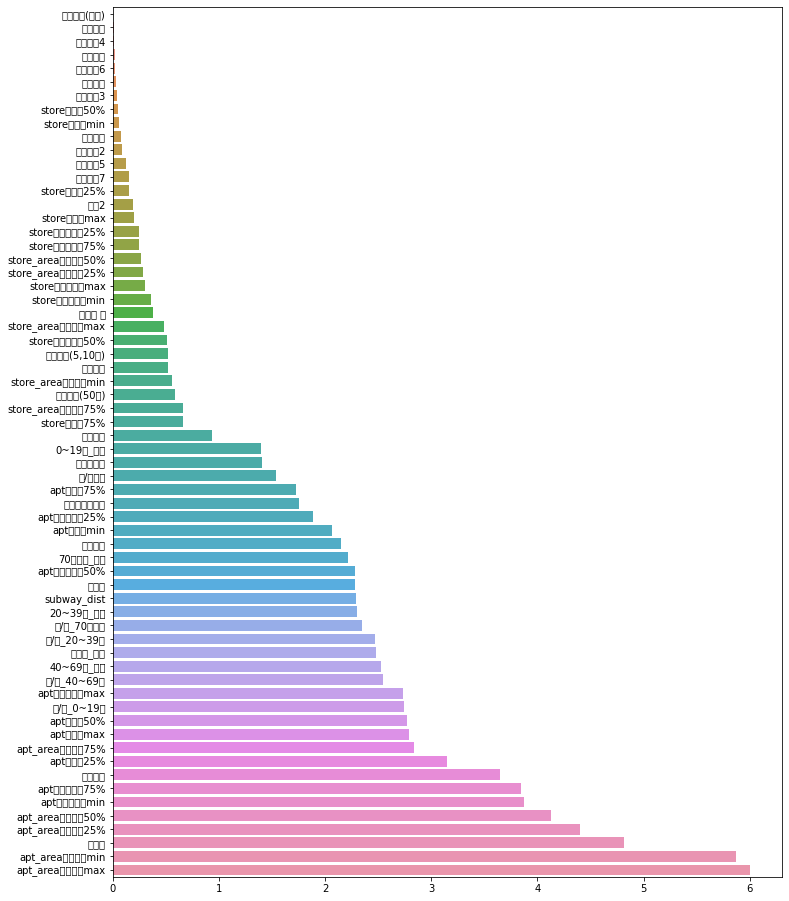

In [18]:
mod = modeling(train1,test1,'등록차량수/총세대수','catboost')
mod.training()
res = mod.model()
pred = mod.testing()

In [19]:
res

109.61177265716861

In [20]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '단지명',
       '도로명주소', '연면적', '위도', '경도', 'subway_name', 'subway_dist', '환승역 수',
       '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세', '남/여_20~39세', '남/여_40~69세',
       '남/여_70세이상', '0~19세_비율', '20~39세_비율', '40~69세_비율', '70세이상_비율',
       '자격유형카테고리'],
      dtype='object')

In [ ]:
# 상가 임대료, 임대보증금도 quantile/ 자격유형 0, 1 / area 아파트기준만
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])
train2,test2 = pr.final()

(414, 27)
====train done====
(147, 26)
====test done====


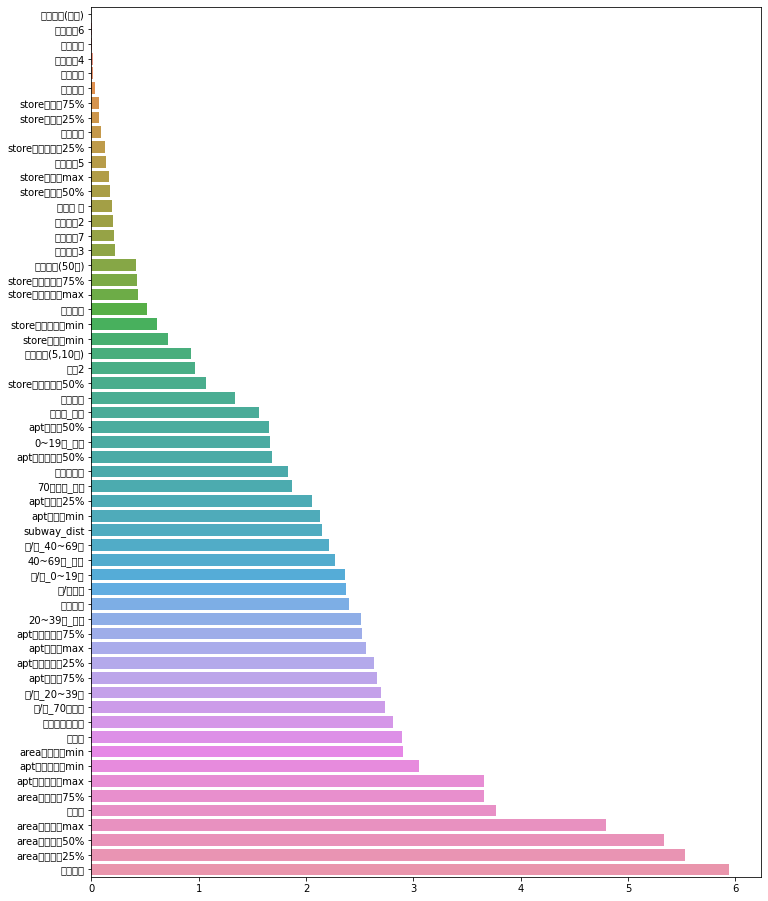

In [ ]:
mod = modeling(train2,test2,'등록차량수/총세대수','catboost')
mod.training()
res2 = mod.model()
pred2 = mod.testing()

In [ ]:
res2

107.33020949444695

In [ ]:
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])
train3,test3 = pr.final()

(414, 27)
====train done====
(147, 26)
====test done====


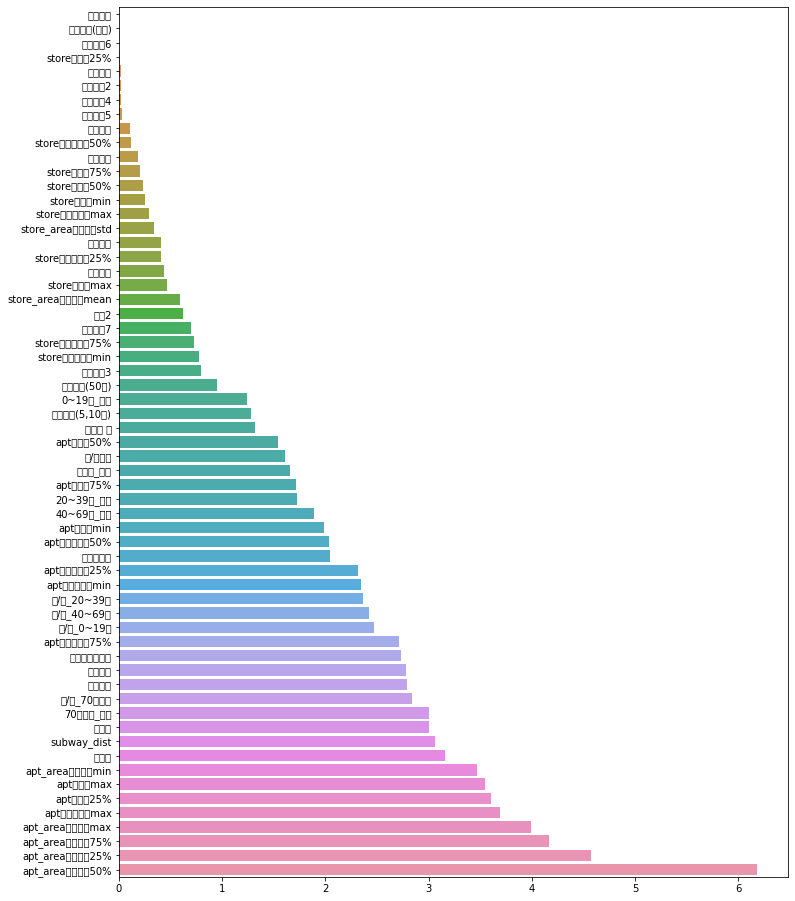

In [ ]:
mod = modeling(train3,test3,'등록차량수/총세대수','catboost')
mod.training()
res3 = mod.model()
pred3 = mod.testing()

In [ ]:
res3

105.56919877256176

In [ ]:
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
pr = preprocess(train,test,['단지코드','지역','단지명','도로명주소','위도','경도','subway_name'])
train4,test4 = pr.final()

(414, 27)
====train done====
(147, 26)
====test done====


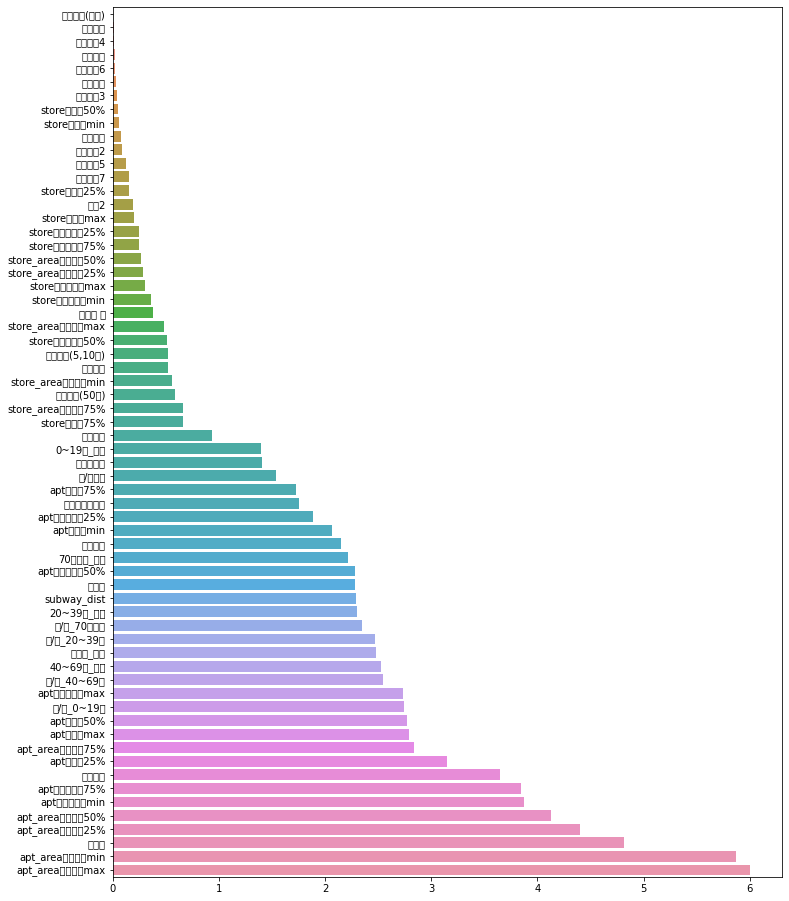

In [ ]:
mod = modeling(train4,test4,'등록차량수/총세대수','catboost')
mod.training()
res4 = mod.model()
pred4 = mod.testing()

In [ ]:
res4

109.61177265716861

In [ ]:
#sub.to_csv(os.path.join(path,"submit_catboost.csv"),index=False)